In [3]:
from rhana.pattern import Rheed, RheedMask

In [4]:
from rhana.io.kashiwa import *

In [5]:
from functools import partial

In [6]:
from rhana.labeler.unet import *

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import pandas as pd
from pathlib import Path

In [8]:
root_folder = Path("../data/unet/")

In [9]:
def convert_path(p):
    p = Path(p)
    p = Path( root_folder, *p.parts[1:] ) # 
    return p

In [10]:
df1 = pd.read_csv(root_folder / "index_old.csv")
df1['crop_path'] = df1['crop_path'].map(lambda x : str(convert_path(x)) )

df2 = pd.read_csv(root_folder / "index.csv")
df = pd.concat((df1, df2))
df = df.set_index("crop_path")
df_index = list( map( Path, df.index ) )
df['IT'] = list( map( lambda x: x.parts[-2], df_index ) )

In [11]:
Inter_ITs = ['IT006', 'IT007', 'IT016', 'IT017', 'IT023', 'IT021']

In [12]:
df['IT'].unique()

array(['IT016', 'IT013', 'IT007', 'IT018', 'IT017', 'IT008', 'IT012',
       'IT010', 'IT009', 'IT006', 'IT015', 'IT014', 'IT011', 'IT020',
       'IT021', 'IT022', 'IT023', 'IT024', 'IT025', 'IT027', 'IT028',
       'IT029', 'IT030'], dtype=object)

In [32]:
# IT = Inter_ITs[-3]
IT = "IT029"

group = df.groupby("IT").get_group(IT)
group = group.copy()
times = group.index.map( partial(get_rheed_time, IT=IT) )
group['time'] = times
group = group.sort_values("time")

In [33]:
len(group)

591

In [34]:
( group['time'].max() - group['time'].min() - 8e11 ) // 1e11

-4.0

In [35]:
group.columns

Index(['image_path', 'full_mask_spot', 'full_mask_stripe', 'crop_args',
       'crop_mask_spot', 'crop_mask_stripe', 'Unnamed: 0', 'full_mask_streak',
       'crop_mask_streak', 'IT', 'time'],
      dtype='object')

In [36]:
d = 20


fig, ax = Rheed.from_image(group.iloc[0].name).plot_pattern()
img = ax.images[0]

def animate(i):
    img.set_array(Rheed.from_image(group.iloc[(i)*d].name).pattern)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(len(group)/d))

plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

In [225]:
img_shape = (200, 400)

In [226]:
len(group)

1620

In [227]:
df.columns

Index(['image_path', 'full_mask_spot', 'full_mask_stripe', 'crop_args',
       'crop_mask_spot', 'crop_mask_stripe', 'Unnamed: 0', 'full_mask_streak',
       'crop_mask_streak', 'IT'],
      dtype='object')

In [228]:
config = dict(kashiwa_config)

In [229]:
config['wave_length'] = hv2wl(exp_voltage[IT])
config['pixel_real'] = cali_exp_pixel_real[IT]

In [230]:
config = RheedConfig(**config)

In [348]:
rdms = []

stripe_c = "crop_mask_stripe"
spot_c = "crop_mask_spot"

for n, row in group.iterrows():
    rd = Rheed.from_image(row.name, config=config)
    stripe_label = rle_decode(row[stripe_c], img_shape) if not pd.isna(row[stripe_c]) else None
    spot_label = rle_decode(row[spot_c], img_shape) if not pd.isna(row[spot_c]) else None
    
    if stripe_label is not None:
        rdm_stripe = RheedMask(rd, stripe_label)
        rdm_stripe.get_regions(with_intensity=False)
        strip_regions = rdm_stripe.filter_regions(10)
    else:
        stripe_label = np.zeros(rd.pattern.shape)
        strip_regions = []
    
    if spot_label is not None:
        rdm_spot = RheedMask(rd, spot_label)
        rdm_spot.get_regions(with_intensity=False)
        spot_regions = rdm_spot.filter_regions(10)
    else:
        spot_label = np.zeros(rd.pattern.shape)
        spot_regions = []
        
    rdm = RheedMask(rd, np.logical_or(stripe_label, spot_label))
    rdm.regions = strip_regions + spot_regions
    
    rdm.get_regions_collapse()
    rdm.clean_collapse()
    rdm.fit_collapse_peaks(height=0.001, threshold=0.000, prominence=0.001)
    rdm.analyze_peaks_distance_cent(tolerant=0.15, abs_tolerant=10, allow_discontinue=1)
    
    rdm.mask = None
#     rdm.rd = None
    
    rdms.append(rdm)

In [349]:
from rhana.phaser.distance import RHEEDMaskDistancePhaser

In [350]:
phaser = RHEEDMaskDistancePhaser(rdms, convert_dist=True)

In [351]:
phaser.run_cluster(eps=1)
phaser.get_intensity_map();

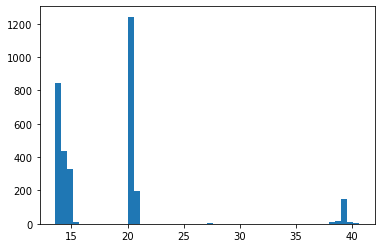

In [352]:
plt.hist( list(phaser.all_peak_dists_values), bins=50 );

In [354]:
list(phaser.dc.mean_dists)

[14.200519315146668, 20.392104169595402, 27.478990127938708, 39.26722340342471]

In [355]:
rdms[0].cluster_labels

array([0])

In [356]:
rdms[0].cluster_labels_unique

array([0])

In [357]:
rdm.collapses_peaks_ws_flatten

array([ 53,  59,  98,  99, 124, 125, 125, 148, 149, 198, 198, 199, 248,
       249, 272, 272, 273, 298, 337, 343])

In [358]:
rdm.collapses_peaks

[array([7]),
 array([7]),
 array([6]),
 array([6]),
 array([6]),
 array([ 9, 15]),
 array([7]),
 array([5]),
 array([ 7, 13]),
 array([5]),
 array([5]),
 array([7]),
 array([6]),
 array([4]),
 array([5]),
 array([7]),
 array([5]),
 array([3])]

In [359]:
rdm.collapses_peaks_flatten_regions

array([ 5,  5,  6, 16,  2, 14,  9,  1, 11,  0, 12, 17,  3, 15,  4, 13, 10,
        7,  8,  8])

In [360]:
rdm

In [361]:
failed = []

for i, rdm in enumerate(rdms):
    try:
        rdm.get_group_intensity()
    except Exception as e:
        print(e)
        failed.append(i)


/home/aurora/anaconda3/envs/fastaiv2/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/aurora/rhana/rhana/pattern.py:712: UserWarning: Gaussian Fail at 6, split regions equally
  warnings.warn(f"Gaussian Fail at {rid}, split regions equally")
/home/aurora/rhana/rhana/pattern.py:712: UserWarning: Gaussian Fail at 7, split regions equally
  warnings.warn(f"Gaussian Fail at {rid}, split regions equally")
/home/aurora/rhana/rhana/pattern.py:712: UserWarning: Gaussian Fail at 13, split regions equally
  warnings.warn(f"Gaussian Fail at {rid}, split regions equally")
/home/aurora/rhana/rhana/pattern.py:712: UserWarning: Gaussian Fail at 16, split regions equally
  warnings.warn(f"Gaussian Fail at {rid}, split regions equally")


In [362]:
failed

[]

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

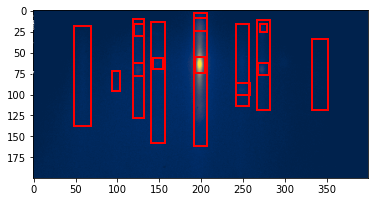

In [363]:
rdms[753].plot_regions()

In [364]:
rdm.group_percent

array([0.58430969, 0.41569031])

In [365]:
rdm.cluster_labels_unique

array([0, 1])

In [366]:
rdm.group_percent

array([0.58430969, 0.41569031])

In [367]:
n_labels = len(np.unique(phaser.dc.labels))

all_multihotencoding = np.zeros( (len(phaser.rdms), n_labels ) )
all_percentage = np.zeros( (len(phaser.rdms), n_labels ) )
all_intensity = np.zeros( (len(phaser.rdms), n_labels ) )
for i, rdm, in enumerate(phaser.rdms):
    all_multihotencoding[i, rdm.cluster_labels_unique] = 1
    all_percentage[i, rdm.cluster_labels_unique] = rdm.group_percent
    all_intensity[i, rdm.cluster_labels_unique] = rdm.group_intensity

best_idx = np.argsort( all_percentage.std(axis=0) )[::-1]

In [368]:
best_idx

array([1, 0, 3, 2])

In [369]:
len(all_percentage)

1620

In [370]:
len(all_percentage[i,:])

4

In [371]:
from scipy.ndimage import uniform_filter1d, minimum_filter1d, gaussian_filter1d

In [372]:
all_percentage.shape

(1620, 4)

Text(0.5, 0, 'Time')

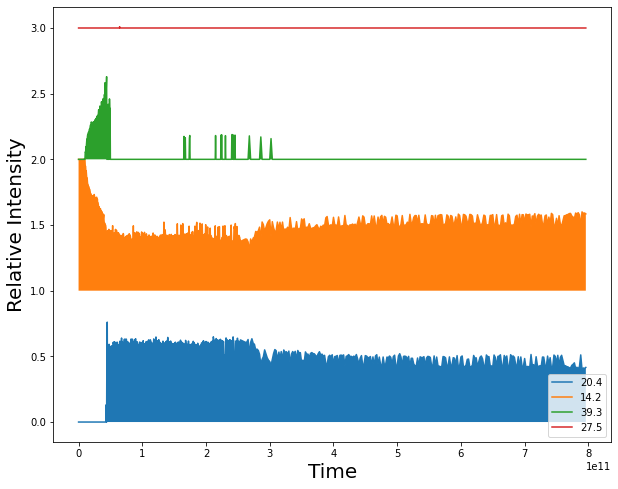

In [374]:
plt.figure(figsize=(10,8))
n=4

for i in range(n):
    x=group['time'].values - group['time'].values.min()
    y=all_percentage[:, best_idx[i]] + i
#     y=gaussian_filter1d(all_percentage[:, best_idx[i]], 3) + i
    plt.plot(
        x,
        y,
        label= round(phaser.dc.mean_dists[best_idx[i]], 1) 
    )
    
    plt.fill_between(x, i, y)

plt.legend()

plt.ylabel("Relative Intensity", fontdict={"size":20})
plt.xlabel("Time", fontdict={"size":20})

In [375]:
# %matplotlib notebook

In [376]:
# Important time stamp
# 0.42 e11
# 0.089 e11
# 0.86 e11
# 7.55 e11

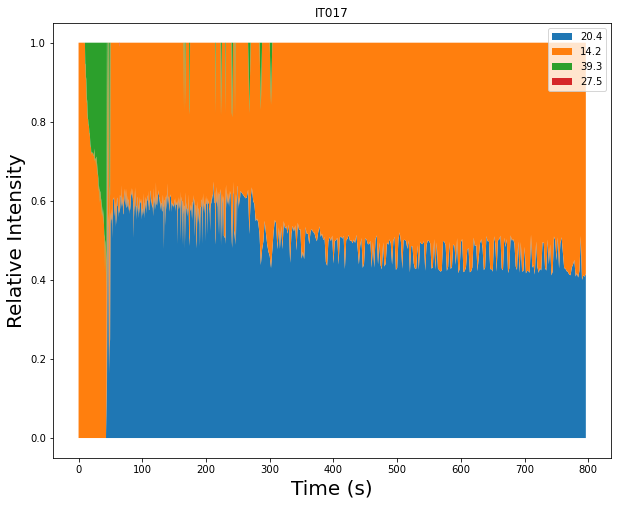

In [377]:
plt.figure(figsize=(10,8))
n=4

cum_y = 0

for i in range(n):
    x= (group['time'].values - group['time'].values.min() ) * 1e-9
    y=all_percentage[:, best_idx[i]]
    
#     y=gaussian_filter1d(all_percentage[:, best_idx[i]], 3) + i
#     plt.plot(
#         x,
#         y,
#         label= round(phaser.dc.mean_dists[best_idx[i]], 1) 
#     )
    
    plt.fill_between(x, cum_y, cum_y +y, label=round(phaser.dc.mean_dists[best_idx[i]], 1))
    cum_y += y
plt.legend()

plt.title(f"{IT}")
plt.ylabel("Relative Intensity", fontdict={"size":20})
plt.xlabel("Time (s)", fontdict={"size":20})
plt.savefig("IT017_dynamic.svg", format = 'svg', dpi=300)

In [ ]:
# merge group

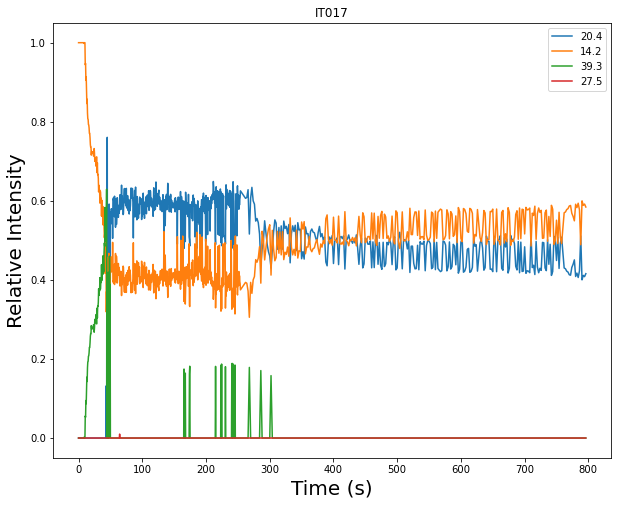

In [378]:
plt.figure(figsize=(10,8))
n=4

cum_y = 0

for i in range(n):
    x = (group['time'].values - group['time'].values.min() ) * 1e-9
    y = all_percentage[:, best_idx[i]]
    
#     y=gaussian_filter1d(all_percentage[:, best_idx[i]], 3) + i
    plt.plot(
        x,
        y,
        label= round(phaser.dc.mean_dists[best_idx[i]], 1) 
    )
    
#     plt.fill_between(x, cum_y, cum_y +y, label=round(phaser.dc.mean_dists[best_idx[i]], 1))
    cum_y += y
plt.legend()

plt.title(f"{IT}")
plt.ylabel("Relative Intensity", fontdict={"size":20})
plt.xlabel("Time (s)", fontdict={"size":20})
plt.savefig("IT017_dynamic.svg", format = 'svg', dpi=300)

In [379]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

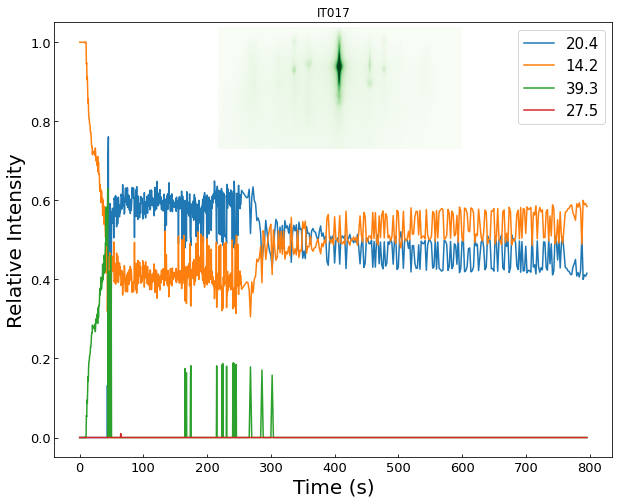

In [381]:
fig, ax = plt.subplots(figsize=(10,8))
axins = inset_axes(ax, width="80%", height="40%", bbox_to_anchor=(.1, .3, .7, .7), bbox_transform=ax.transAxes,)
n=4

cum_y = 0

for i in range(n):
    x = (group['time'].values - group['time'].values.min() ) * 1e-9
    y = all_percentage[:, best_idx[i]]
    
#     y=gaussian_filter1d(all_percentage[:, best_idx[i]], 3) + i
    ax.plot(
        x,
        y,
        label= round(phaser.dc.mean_dists[best_idx[i]], 1) 
    )
    
#     plt.fill_between(x, cum_y, cum_y +y, label=round(phaser.dc.mean_dists[best_idx[i]], 1))
    cum_y += y
    
rd.plot_pattern(ax=axins, cmap='Greens')
    
img = axins.images[0]
axins.axis("off")
ax.legend(fontsize=15)
ax.set_title(f"{IT}")
ax.set_ylabel("Relative Intensity", fontdict={"size":20})
ax.set_xlabel("Time (s)", fontdict={"size":20})
ax.tick_params(axis='both', labelsize=13, direction="in" )

In [313]:
smoothed_all_percentage = []


kernel = np.array([1, 1, 1, 1, 1])
kernel = kernel / sum(kernel)

for i in range(all_percentage.shape[1]):
    y = np.convolve( kernel, all_percentage[:, best_idx[i]], 'same')

    smoothed_all_percentage.append(y)
    
smoothed_all_percentage = np.stack(smoothed_all_percentage, axis=1)

In [406]:
d = 10

fig, ax = plt.subplots(figsize=(10,8), facecolor='white', dpi=100)
axins = inset_axes(ax, width="80%", height="40%", bbox_to_anchor=(-.1, .2, .8, .8), bbox_transform=ax.transAxes,)
n=3

for i in range(n):
    ax.plot(
        [],
        [],
        label= round(phaser.dc.mean_dists[best_idx[i]], 1),
        linewidth=2
    )
    ax.scatter(
        [],
        [],
        s = 100,
        linewidths=1,
        edgecolor='black',
        zorder = 100
    )

rd.plot_pattern(ax=axins, cmap='Greens')
    
img = axins.images[0]
axins.axis("off")
ax.legend(title=r"Distance (nm$^{-1}$)", fontsize=20, title_fontsize=20)
ax.set_ylabel("Relative Intensity", fontdict={"size":25})
ax.set_xlabel("Time (s)", fontdict={"size":25})    
ax.tick_params(axis='both', labelsize=17, direction="in", length=5 )

x = (group['time'].values - group['time'].values.min() ) * 1e-9
y = all_percentage[:, best_idx[i]]
ax.set_xlim(0, x.max()*1.1)
ax.set_ylim(0, 1.1)

plt.close(fig)

def animate(i):    
    for j in range(n):        
        x = (group['time'].values[:i*d] - group['time'].values.min() ) * 1e-9
        y = all_percentage[:, best_idx[j]][:i*d]
        ax.lines[j].set_data(x, y)
        if len(x)>0:
            ax.collections[j].set_offsets([x[-1], y[-1]])
        
    img.set_array(np.clip(Rheed.from_image(group.iloc[i*d].name).pattern, 0, 0.3)/0.3)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(len(group)/d))


# from IPython.display import HTML
# HTML(ani.to_jshtml())

In [407]:
f = f"publication/{IT}_timedynamic.mp4" 
writer = matplotlib.animation.FFMpegWriter(fps=5) 
ani.save(f, writer=writer)